# Model Selection Notebook

**Objective:** Compare FNN, RNN and Transformer on FPL player‐sequence data, tune key hyperparameters, visualize training, and select the best model for evaluation


### Getting the Data

We use the `make_dataset.py` script to transform processed data into a model-ready format. This includes:

- Dropping the necessary columns
- Creating time sequences
- Handling missing values
- Creating attention masks


What do we need to do:

- Splitting into training/validation/test sets
- Comparing different model architectures
- Visualizing the training and model selection
- Hyperparameter tuning


In [185]:
# for corrent imports
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent  
SRC_DIR       = PROJECT_ROOT / "src"
DATA_DIR      = PROJECT_ROOT / "data"

sys.path.insert(0, str(SRC_DIR))       


In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import math
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from data.make_dataset import prepare_player_sequences, FPLPlayerSequenceDataset
from sklearn.preprocessing import StandardScaler
import joblib

In [ ]:
# generate sequences
# work on the time issue
sequences, masks, targets = prepare_player_sequences(
    df_path=str(DATA_DIR / "processed_data.csv"),
    target_col="total_points",
    max_gws_in_sequence= 38,
)



--- Starting Data Preparation for Sequences from C:\Users\asus\OneDrive\Desktop\projects\AI_project\data\processed_data.csv ---
Successfully loaded data. Shape: (28742, 192)

--- Cleaning Data and Selecting Numeric Features ---
Column 'name' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'position' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'team' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'kickoff_time' is of type object and couldn't be converted to numeric. Marked for dropping.
Column 'xP' is of dropped for preventing data leakage.
Column 'assists' is of dropped for preventing data leakage.
Column 'bonus' is of dropped for preventing data leakage.
Column 'bps' is of dropped for preventing data leakage.
Column 'clean_sheets' is of dropped for preventing data leakage.
Column 'creativity' is of dropped for preventing data leakage.
Column 'expected_assists' is of dropped

In [224]:
# train/val/test split
# we do it a chronological way 

n = sequences.shape[0]

train_end = int(n * 0.70)          
val_end   = train_end + int(n * 0.15)  

train_idx = np.arange(0, train_end)
val_idx   = np.arange(train_end, val_end)
test_idx  = np.arange(val_end, n)


In [ ]:
scaler = StandardScaler()
print("Fitting StandardScaler on training data features...")

train_sequences_reshaped = sequences[train_idx].reshape(-1, sequences.shape[2])

scaler.fit(train_sequences_reshaped)


def scale_3d_sequences(sequence_array_3d, fitted_scaler):
    if sequence_array_3d.shape[0] == 0: # Handle empty array
        return sequence_array_3d 
    
    original_shape = sequence_array_3d.shape
    num_features_in_array = original_shape[2]
    
    # Reshape to 2D: [N_samples_in_split * S_seq_len, F_features]
    reshaped_array = sequence_array_3d.reshape(-1, num_features_in_array)
    
    # Transform using the FITTED scaler
    scaled_reshaped_array = fitted_scaler.transform(reshaped_array)
    
    # Reshape back to original 3D shape
    return scaled_reshaped_array.reshape(original_shape)


print("Scaling train, val, and test sequences using the fitted scaler...")
sequences_train_scaled = scale_3d_sequences(sequences[train_idx], scaler)
sequences_val_scaled = scale_3d_sequences(sequences[val_idx], scaler)
sequences_test_scaled = scale_3d_sequences(sequences[test_idx], scaler)

Fitting StandardScaler on training data features...
Scaling train, val, and test sequences using the fitted scaler...


In [226]:
masks_train = masks[train_idx]
targets_train = targets[train_idx]

masks_val = masks[val_idx]
targets_val = targets[val_idx]

masks_test = masks[test_idx]
targets_test = targets[test_idx]


train_ds = FPLPlayerSequenceDataset(sequences_train_scaled, targets_train, masks_train) 
val_ds = FPLPlayerSequenceDataset(sequences_val_scaled, targets_val, masks_val)     
test_ds = FPLPlayerSequenceDataset(sequences_test_scaled, targets_test, masks_test)     




train_loader = DataLoader(train_ds, batch_size=64, shuffle=True) 
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)


print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

Train/Val/Test sizes: 20119/4311/4312


In [227]:
sample_seq, sample_mask, sample_target = next(iter(train_loader))
print(f"Sample batch - Sequences shape: {sample_seq.shape}")      # (batch_size, gameweeks, num_features)
print(f"Sample batch - Attention Mask shape: {sample_mask.shape}") # (batch_size, gameweeks)
print(f"Sample batch - Targets shape: {sample_target.shape}")       # (batch_size, 1)         


Sample batch - Sequences shape: torch.Size([64, 38, 160])
Sample batch - Attention Mask shape: torch.Size([64, 38])
Sample batch - Targets shape: torch.Size([64, 1])


## Model Architectures Under Consideration

We define three architectures:
- **FNN**: flatten inputs  
- **RNN**: LSTM-based sequence model  
- **Transformer**: self-attention encoder  

All share the same input dims.

**Loss Function:** We aim to predict FPL points, a continuous numerical value, making this a regression task. Common loss functions include Mean Squared Error (`nn.MSELoss()`), which heavily penalizes large errors, or Mean Absolute Error (`nn.L1Loss()`), which is less sensitive to outliers. We will start with `nn.MSELoss()`.

### FNN

In [228]:
# FNN
class FNN(pl.LightningModule):
    def __init__(self, seq_len, n_features, hidden_dim=256, dropout=0.5, lr=1e-3, weight_decay = 1e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(seq_len * n_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )
        self.criterion = nn.MSELoss()

        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, x, mask=None):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)          

        loss = self.criterion(preds, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def test_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
        
        return loss


    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer
    
        # Optional: Add a learning rate scheduler
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
        # return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}


### RNN

In [229]:
# RNN
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNN(pl.LightningModule):
    def __init__(self, n_features, hidden_dim=256, n_layers=2, dropout=0.2, lr=1e-3, weight_decay = 1e-5):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_dim, 1)

        
        self.criterion = nn.MSELoss()

        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, x, mask):
        out, _ = self.lstm(x)
        lengths = mask.sum(dim=1)       
        idx = lengths - 1                


        if (lengths == 0).any():
            # This is a problematic batch. How to handle?
            # Option 1: Raise error (stops training, indicates data issue)
            # raise ValueError("Encountered sequence with zero length in RNN forward pass.")
            # Option 2: Try to output zeros (might hide data issues but prevent crash)
            print("WARNING: RNN forward encountered sequence(s) with zero length!")
            # Create a zero output of the expected shape. This is a HACK.
            # It's better to fix the data so this doesn't happen.
            return torch.zeros(x.size(0), 1, device=x.device, dtype=x.dtype)
      
        
        last = out[torch.arange(out.size(0)), idx]
        return self.fc(last)
    

    def training_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer
    


### Transformer

As transformers can't understand the order of the sequences we add a positional encoding to teach the order of gameweeks

In [230]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout = 0.1, sequence_length = 38): 
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(sequence_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(sequence_length, 1, d_model)
        
        
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe.squeeze(1)
        return self.dropout(x)

Then we use encoder only transformer model with a linear classification head

In [231]:
class Transformer(pl.LightningModule):
    def __init__(self,
                 input_features_dim,
                 d_model = 64,
                 nhead = 4,
                 num_encoder_layers = 1,
                 dim_feedforward = 128,
                 dropout = 0.2,
                 sequence_length = 38,
                 lr = 1e-3, #change
                 weight_decay = 1e-5):
        
        super().__init__()
        self.save_hyperparameters()


        # input projection layer necessary for positional encoding 
        self.input_projection = nn.Linear(input_features_dim, d_model)
        nn.init.xavier_uniform_(self.input_projection.weight, gain=0.1)
        nn.init.zeros_(self.input_projection.bias)

        self.input_norm = nn.LayerNorm(d_model) #this solved it

        self.pos_encoder = PositionalEncoding(d_model, dropout, sequence_length=sequence_length)


        # encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True 
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)


        # prediction head that predicts a single value (total_points)
        self.output_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1) 
        )

        self.criterion = nn.MSELoss() 

        self.lr = lr
        self.weight_decay = weight_decay


    def _check_tensor_for_nan_inf(self, tensor, name="tensor"): #used for debugging
        has_nan = torch.isnan(tensor).any()
        has_inf = torch.isinf(tensor).any()
        if has_nan or has_inf:
            print(f"INVALID VAL DETECTED in {name}: NaNs? {has_nan}, Infs? {has_inf}. Shape: {tensor.shape}")
            # print(f"Sample values from {name}: {tensor.flatten()[:10]}") # Be careful printing large tensors
            return True
        return False


    def forward(self, x, mask):
        x = self.input_projection(x) # [batch_size, seq_len, d_model] 
        x = self.input_norm(x)  
        x = nn.ReLU()(x) # Apply activation

        self._check_tensor_for_nan_inf(x, "After input_projection")

        # Add positional encoding
        x = self.pos_encoder(x)
        

        # Pass through Transformer Encoder
        transformer_padding_mask = ~mask # Invert: True for padded, False for valid
        encoded_sequence = self.transformer_encoder(x, src_key_padding_mask=transformer_padding_mask) 

                
        # can't feed a 3d tensor into a linear so 
        batch_size = encoded_sequence.size(0)
        sequence_lengths = mask.sum(dim=1) 
        idx = sequence_lengths-1 # index of last valid gameweek

        # turn into 2D and use the final week that captures the context of previous weeks to decide the total points
        final_representation = encoded_sequence[torch.arange(batch_size), idx, :] 
        
        prediction = self.output_head(final_representation) # [batch_size, 1]
        return prediction


    def training_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
        return loss


    def test_step(self, batch, batch_idx):
        x, mask, y = batch
        preds = self(x, mask)

        loss = self.criterion(preds, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
        
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer
    

## Training

In [235]:
# Number of features and sequence length
n_feats = sequences.shape[-1]
seq_len = 38

# Instantiate each LightningModule
models = {
    
    "FNN": FNN(
        seq_len=seq_len,
        n_features=n_feats,
    ),
    "RNN": RNN(
        n_features=n_feats,

    ),
    
    "Transformer": Transformer(
        input_features_dim=n_feats,
    ),
}



In [236]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger #use tensorboard here
from pytorch_lightning.loggers import TensorBoardLogger



logger = TensorBoardLogger("tb_logs", name="fpl_experiment") 



final_val_losses = {}
csv_log_paths = {}



# Fit each model
for name, model in models.items():

    logger = CSVLogger("csv_logs", name="fpl_experiment")

    csv_log_paths[name] = logger.log_dir + "/metrics.csv"

    print(f"▶ Training {name}")
    trainer = Trainer(
    max_epochs=10,
    logger=logger,
    gradient_clip_val= 1
    )
    
    trainer.fit(
        model=model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
    )

    print(f"Available metrics for model {name}: {model.trainer.callback_metrics.keys()}")

    val_loss = float(model.trainer.callback_metrics["val_loss"])
    final_val_losses[name] = val_loss
    print(f"{name} final val_loss = {val_loss:.4f}")


# 3. Select best
best_name = min(final_val_losses, key=final_val_losses.get)
best_model = models[best_name]
print(f"\n✅ Best model: {best_name} (val_loss={final_val_losses[best_name]:.4f})")


# Test
print("\n▶ Testing best model")
test_results = trainer.test(
    model=best_model,
    dataloaders=test_loader,
)
print(test_results)




Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 1.6 M  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.491     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


▶ Training FNN
                                                                            

c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 315/315 [00:03<00:00, 87.46it/s, v_num=10, train_loss=1.380, val_loss=5.630] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 315/315 [00:03<00:00, 86.03it/s, v_num=10, train_loss=1.380, val_loss=5.630]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



Available metrics for model FNN: dict_keys(['train_loss', 'val_loss'])
FNN final val_loss = 5.6251
▶ Training RNN


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 954 K  | train
1 | fc        | Linear  | 257    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
954 K     Trainable params
0         Non-trainable params
954 K     Total params
3.818     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 315/315 [00:07<00:00, 43.94it/s, v_num=11, train_loss=0.519, val_loss=1.900] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 315/315 [00:07<00:00, 43.69it/s, v_num=11, train_loss=0.519, val_loss=1.900]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



Available metrics for model RNN: dict_keys(['train_loss', 'val_loss'])
RNN final val_loss = 1.9049
▶ Training Transformer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | input_projection    | Linear             | 10.3 K | train
1 | input_norm          | LayerNorm          | 128    | train
2 | pos_encoder         | PositionalEncoding | 0      | train
3 | transformer_encoder | TransformerEncoder | 33.5 K | train
4 | output_head         | Sequential         | 2.1 K  | train
5 | criterion           | MSELoss            | 0      | train
-------------------------------------------------------------------
46.0 K    Trainable params
0         Non-trainable params
46.0 K    Total params
0.184     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 315/315 [00:05<00:00, 59.64it/s, v_num=12, train_loss=0.0942, val_loss=0.705]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 315/315 [00:05<00:00, 59.49it/s, v_num=12, train_loss=0.0942, val_loss=0.705]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Available metrics for model Transformer: dict_keys(['train_loss', 'val_loss'])
Transformer final val_loss = 0.7049

✅ Best model: Transformer (val_loss=0.7049)

▶ Testing best model


c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 125.33it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.39891061186790466    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.39891061186790466}]


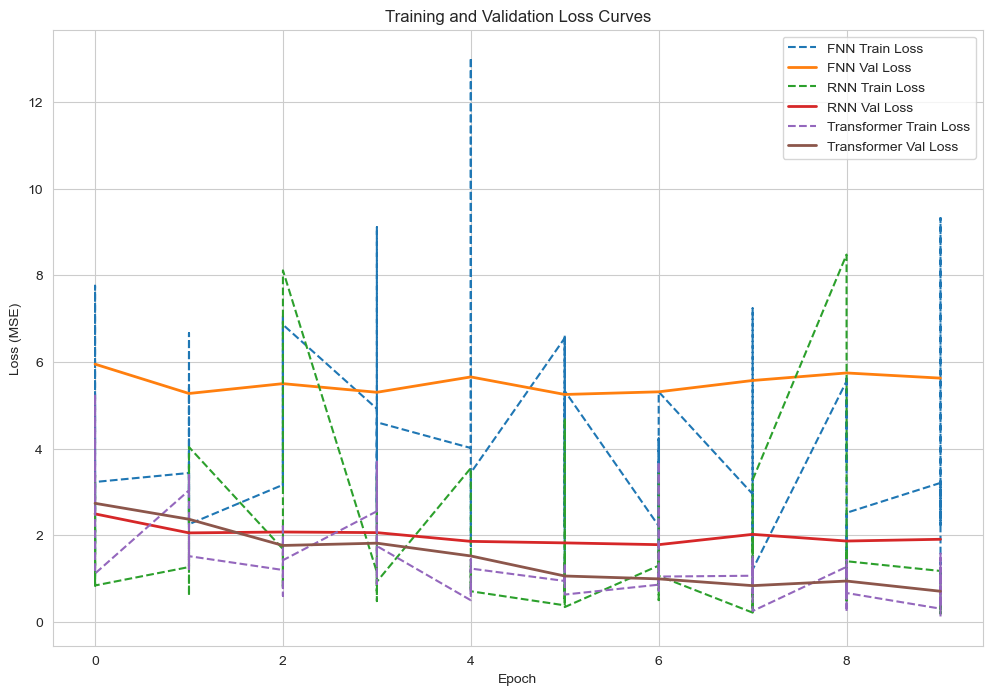

In [237]:
# Plotting after all models have trained
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

for model_name, log_path in csv_log_paths.items():

    try:
        metrics_df = pd.read_csv(log_path)
        
        # Plot training loss (usually logged per step, then epoch average)
        # We are interested in epoch-level losses for this plot.
        # CSVLogger might save step-wise and epoch-wise. Look for 'epoch' column.
        # If 'train_loss' is logged with on_epoch=True, it appears with an epoch number.
        # If 'train_loss_step' and 'train_loss_epoch' exist, use 'train_loss_epoch'.
        # For simplicity, let's assume 'epoch' column exists and 'train_loss' is the epoch avg.

        if 'epoch' in metrics_df.columns:
            epoch_metrics = metrics_df.dropna(subset=['epoch']) # Ensure epoch is not NaN
            
            if 'train_loss' in epoch_metrics.columns: # Check if epoch-level train_loss exists
                # If train_loss is logged per step, there might be multiple entries per epoch.
                # We need the epoch-level summary. If your `self.log` for train_loss has
                # on_step=False, on_epoch=True, then 'train_loss' will be the epoch average.
                # If it was on_step=True, on_epoch=True, you might have 'train_loss_step' and 'train_loss_epoch'.
                # Let's assume 'train_loss' in the CSV is the one we want per epoch.
                # We need to handle cases where 'train_loss' might be NaN for rows where only 'val_loss' is logged.
                train_loss_data = epoch_metrics.dropna(subset=['train_loss'])
                plt.plot(train_loss_data['epoch'], train_loss_data['train_loss'], 
                         label=f'{model_name} Train Loss', linestyle='--')

            if 'val_loss' in epoch_metrics.columns:
                val_loss_data = epoch_metrics.dropna(subset=['val_loss']) # val_loss is logged per epoch
                plt.plot(val_loss_data['epoch'], val_loss_data['val_loss'], 
                         label=f'{model_name} Val Loss', linewidth=2)
        else:
            print(f"Warning: 'epoch' column not found in {log_path} for {model_name}. Cannot plot epoch-wise.")

    except FileNotFoundError:
        print(f"Log file not found for {model_name} at {log_path}")
    except Exception as e:
        print(f"Error processing log for {model_name}: {e}")

plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()